<a href="https://colab.research.google.com/github/xtinachen/w266-beauty/blob/main/Distinctions_In_Beauty_Product_Advertising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distinctions in Beauty Product Advertising 


# Libraries

In [ ]:
# All of the data is in a shared Google Drive folder. Mount drive for access. 
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Install textstat to analyze text complexity.
!pip install textstat

In [ ]:
# Install Transformers for Embeddings.
!pip install transformers

In [ ]:
# General Loading and Processing.
from google.colab import drive
import pandas as pd 
import spacy
import numpy as np
import glob
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import itertools
from scipy.stats import zscore
from scipy import stats
import random

# Text Processing.
import textstat
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('punkt')  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter
from collections import OrderedDict

# Modeling.
import tensorflow_hub as hub
import tensorflow as tf
from sklearn import preprocessing
import transformers as transformer
import torch
import gensim
import gensim.downloader
from tqdm import tqdm
import keras

# Load Data

In [ ]:
# Truncate size of output.
pd.set_option('max_colwidth', 400)

### Lotion Products

In [ ]:
lotions_path = '/content/gdrive/MyDrive/266/final/data/hair_scraped_latest_cl.csv'
lotion_df = pd.read_csv(lotions_path) 

### Hair Products

In [ ]:
hair_path = '/content/gdrive/MyDrive/266/final/data/hair_scraped_latest_cl.csv'
hair_df = pd.read_csv(hair_path)

### All Junglescout Products

In [ ]:
raw_junglescout_path = '/content/gdrive/MyDrive/266/final/data/junglescout/all_raw_junglescout_categorized.csv'
all_products_df = pd.read_csv(raw_junglescout_path)

## Build a Corpus of Marketing Terms

For extracting marketing terms, we tokenized titles and tagged them with their parts of speech using the nltk word_tokenize and pos_tag functions. After extracting all adjectives, we filtered out what we felt were purely marketing terms. 

In [ ]:
adjective_tags = ["JJ", "JJR", "JJS"] 
adjectives = set()

In [ ]:
# Tokenize data and extract adjectives. 
for product_title in lotion_df["product_title_cl"]:
  words_and_tags = nltk.pos_tag(word_tokenize(product_title))
  for word, tag in words_and_tags:
    if tag in adjective_tags:
      adjectives.add(word)

# Lotion Analysis

## Data Manipulation

In [ ]:
# Reduce dataset to only columns we're interested in. 
lotion_df = lotion_df[["product_id", "product_title_cl", 'title_cl', 'about_cl', 'description_cl', "price_cl", 'price_unit', 'ingredients', "category", "full_text", "title"]]
# Remove all products where the unit price is NAN
lotion_df = lotion_df[lotion_df['price_unit'].notna()]
# Reset the index to ensure linearity. 
lotion_df = lotion_df.reset_index()

In [ ]:
lotion_df.shape

(2487, 12)

Remove Outliers: [Source](https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python)

In [ ]:
# Remove Outliers 
z_scores = stats.zscore(lotion_df["price_unit"].values)
abs_z_scores = np.abs(z_scores).reshape(-1,1)
filtered_entries = (abs_z_scores < 1.7).all(axis=1)
lotion_df = lotion_df[filtered_entries]

In [ ]:
# Number of unique product_ids.  
len(lotion_df.product_id.unique())

2464

In [ ]:
# Examine the sub-categories in the lotion dataset. 
lotion_df["category"].value_counts()

shampoo        1496
conditioner     968
Name: category, dtype: int64

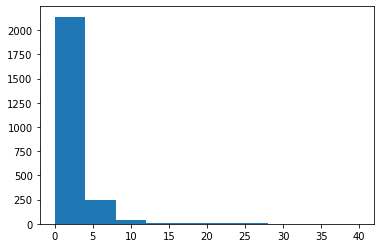

In [ ]:
# Examine the distribution of price per unit (ounces).
plt.hist(lotion_df['price_unit'], range=[0,40])
plt.show()

In [ ]:
lotion_df["price_unit"].describe()

count    2464.000000
mean        2.489824
std         2.857140
min         0.017240
25%         1.081667
50%         1.720714
75%         2.833885
max        32.950000
Name: price_unit, dtype: float64

In [ ]:
# Value to split products into lower and higher priced lotion products
cutoff_lotion = lotion_df["price_unit"].median()
cutoff_lotion

1.7207142857142856

## Freedman and Jurafsky Analysis (Scaled)


### Falutin

Flesch Reading Score and Grade Level

In [ ]:
# The flesch kincaid grade indicates the grade that a student would be able to read
# the text. For example, a 9.3 means a ninth grader could read the text. 
lotion_df["flesch_kincaid_grade"] = lotion_df["full_text"].apply(textstat.flesch_kincaid_grade)

# The flesch read ease score has no lower bound, but has an upper bound of 121.22. 
# The lower the score is, the harder the text is to read. 
lotion_df["reading_ease"] = lotion_df["full_text"].apply(textstat.flesch_reading_ease)

Number of Words

In [ ]:
# Count the number of words present in the text (does not include punctuation by default).
lotion_df["lexicon_count"] = lotion_df["full_text"].apply(textstat.lexicon_count)

Word Commonality

In [ ]:
# Raw marketing terms (hand curated).
marketing_term_corpus = ["absorbing","active","advanced","all natural","aloe","aluminum","anti aging",
     "antioxidant","antiwrinkle","attractant","authentic","best","botanic","bpa",
     "certified","classic","clean","cleanser","clear","clinically","coconut",
     "collagen","comedogenic","cosmeceutical","creamy","curvy","deep","dermatologist",
     "double","dry","dual","elite","essential","essential oil","esthetic","extra",
     "facial","fair","fda","finish","fragrance","fragrant","free","fullest","gentle",
     "glow","gluten","glycolic","green","healthiest","healthy","herbal","hygienic",
     "hypoallergenic","iluminate","incredible","intense","intensive","keeper","kosher",
     "lavish","light","liquid","lucious","lux","maximum","microbiotic","miracle",
     "multifunctional","natural","neutral","nongreasy","norwegian","odorfree","oilcontrol",
     "oilfree","olive","organic","original","pabafree","paraben","parabenfree",
     "phytoactive","poppy","premium","protective","pure","purest","purpose","rapid",
     "raw","resistant","restorative","rich","royale","safe","select","sensitive",
     "shave","shea","sheamoisture","silicon","silicone","silk","skin","smart","soft",
     "solar","soothe","soothing","spotlight","stress","sublime","suntan","tan",
     "texturized","therapy","touch","transformative","tropical","ultimate","unisex",
     "unprocessed","uplift","urban","uv","uva","uvb","vegan","virgin","vitae",
     "vitamin","youthful","zen"]

# Lemmatized.
marketing_term_corpus_cl = ['absorb', 'activ', 'advanc', 'natur', 'alo', 'aluminum', 
                            'anti age', 'antioxid', 'antiwrinkl', 'attract', 'authent', 
                            'best', 'botan', 'bpa', 'certifi', 'classic', 'clean', 'cleanser', 
                            'clear', 'clinic', 'coconut', 'collagen', 'comedogen', 'cosmeceut', 
                            'creami', 'curvi', 'deep', 'dermatologist', 'doubl', 'dri', 'dual', 
                            'elit', 'essenti', 'essenti oil', 'esthet', 'extra', 'facial', 'fair', 
                            'fda', 'finish', 'fragranc', 'fragrant', 'free', 'fullest', 'gentl', 
                            'glow', 'gluten', 'glycol', 'green', 'healthiest', 'healthi', 'herbal', 
                            'hygien', 'hypoallergen', 'ilumin', 'incred', 'intens', 'intens', 
                            'keeper', 'kosher', 'lavish', 'light', 'liquid', 'luciou', 'lux', 
                            'maximum', 'microbiot', 'miracl', 'multifunct', 'natur', 'neutral', 
                            'nongreasi', 'norwegian', 'odorfre', 'oilcontrol', 'oilfre', 'oliv', 
                            'organ', 'origin', 'pabafre', 'paraben', 'parabenfre', 'phytoact', 
                            'poppi', 'premium', 'protect', 'pure', 'purest', 'purpos', 'rapid', 
                            'raw', 'resist', 'restor', 'rich', 'royal', 'safe', 'select', 
                            'sensit', 'shave', 'shea', 'sheamoistur', 'silicon', 'silicon', 
                            'silk', 'skin', 'smart', 'soft', 'solar', 'sooth', 'sooth', 
                            'spotlight', 'stress', 'sublim', 'suntan', 'tan', 'textur', 'therapi', 
                            'touch', 'transform', 'tropic', 'ultim', 'unisex', 'unprocess', 'uplift', 
                            'urban', 'uv', 'uva', 'uvb', 'vegan', 'virgin', 'vita', 'vitamin', 'youth', 'zen']

In [ ]:
# Count the occurances of marketing terms in the text. 
def count_marketing_terms(text):
  count = 0
  for word in text.split(" "):
    if word in marketing_term_corpus_cl: 
      count += 1 
  return count

In [ ]:
# Raw count of marketing terms present. 
lotion_df["marketing_term_count_raw"] = lotion_df["full_text"].apply(count_marketing_terms)

In [ ]:
# Examine falutin variables (as a whole).
lotion_df[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,2464.000000,2464.000000,2464.000000,2464.000000
mean,33.324107,-2.362658,79.426136,8.640828
std,27.288936,73.259133,69.118892,8.756718
min,0.900000,-634.630000,5.000000,0.000000
25%,15.800000,-23.260000,35.000000,3.000000
50%,25.100000,17.340000,58.000000,6.000000
75%,40.400000,45.090000,98.250000,12.000000
max,276.700000,104.640000,704.000000,83.000000


In [ ]:
# Split dataset based on the median of the price. 
lower_priced_products = lotion_df[lotion_df['price_unit'] <= cutoff_lotion]
higher_priced_products = lotion_df[lotion_df['price_unit'] > cutoff_lotion]

In [ ]:
# Examine distribution of falutin variables for lower priced products. 
lower_priced_products[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,34.793344,-6.378782,83.088474,9.103896
std,27.358890,73.396034,69.307268,8.947300
min,2.900000,-379.870000,7.000000,0.000000
25%,16.600000,-28.000000,37.000000,3.000000
50%,26.300000,14.980000,59.000000,7.000000
75%,42.300000,41.370000,103.000000,12.000000
max,178.800000,97.540000,453.000000,55.000000


In [ ]:
# Examine distribution of falutin variabels for higher priced products. 
higher_priced_products[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,31.854870,1.653466,75.763799,8.177760
std,27.150457,72.930778,68.763208,8.540441
min,0.900000,-634.630000,5.000000,0.000000
25%,14.600000,-18.870000,33.000000,2.000000
50%,23.600000,20.050000,55.000000,5.500000
75%,38.875000,48.132500,95.000000,11.000000
max,276.700000,104.640000,704.000000,83.000000


### Distinction

#### Unique and Comparator Words: Baseline

As a baseline anlaysis, we hand-curated a list of words that indicate "uniqueness". This feature will just indicate the number of unique words present in the title.

In [ ]:
unique_and_comparator_words = ["unique", "different", "most", "distinct", "special", "single", "only", "new", 'premium', 'ultra',"more", "less", "most", "better", "lower", "higher", "far", "farther", "little", "simpler", "least"]
# most and only got removed due to stop words, add back in? 
unique_and_comparator_words_cl = ['uniqu', 'differ', 'distinct', 'special', 'singl', 'new', 'premium', 'ultra','less', 'better', 'lower', 'higher', 'far', 'farther', 'littl', 'simpler', 'least'] 
def count_unique_and_comparator_words(text):
  count = 0
  for word in unique_and_comparator_words_cl:
    if word in text.lower().split(' '):
      count += 1
  return count 

# lotion_df["unique_word_count_basic"] = lotion_df["product_title_cl"].apply(count_unique_and_comparator_words)
lotion_df["unique_word_count_basic"] = lotion_df["full_text"].apply(count_unique_and_comparator_words)
lotion_df["unique_word_count_basic"].describe()

count    2464.000000
mean        0.313718
std         0.614646
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: unique_word_count_basic, dtype: float64

This method provided next to no signal. 

#### Unique and Comparator Words: Improvement

We tried two different things to improve this signal. 

**1. Unigrams, Bigrams, Trigrams Using a Custom Word2Vec Model**

First, we extracted unigrams, bigrams and trigrams. We combined the bigrams and trigrams by underscores to create unique unigrams capturing the two or three words. Then we created our own embeddings using a custom Word2Vec model. 

In [ ]:
# Get unigrams, bigrams and trigrams of product title.
def connect_by_underscore(ngram_list):
  new_list = []
  for ngram in ngram_list:
    new_list.append("_".join(ngram))
  return new_list
    
# Extract unigrams, bigrams and trigrams. 
# Think we should remove prod from unigram/bigram/trigram.
lotion_df["unigrams"] = lotion_df["full_text"].apply(lambda x: np.array(str.split(x)))
lotion_df["bigrams"] = lotion_df["unigrams"].apply(nltk.bigrams).apply(list).apply(connect_by_underscore)
lotion_df["trigrams"] = lotion_df["unigrams"].apply(nltk.trigrams).apply(list).apply(connect_by_underscore)

In [ ]:
# Examine Unigrams
lotion_df["unigrams"][:5]

0    [silicon, mix, silicon, mix, bambu, extract, nutrit, prod, oz, ounc, nutrit, prod, bamboo, extract, regener, nourish, vitamin, e, c, f, carthamu, oil, almond, oil, improv, health, beauti, hair, hair, type, includ, natur, process, hair, follow, silicon, mix, bambu, treatment, good, result, work, great, brittl, dull, hair, free, residu, improv, silicon, mix, bambu, treatment, ', s, effici]
1                                                                                                                                                                   [clay, esth, prod, ex, oz, refil, improv, health, scalp, hair, keep, scalp, healthi, remov, dirt, excess, oil, sweat, caus, clog, pore, increa, moistur, soft, loosen, tension, caus, scalp, relax, leav, hair, moistur, soft, healthi]
2                                                                                                                      [healthi, sexi, hair, triwheat, leav, prod, oz, power, combin, soy, cocoa, work, synergis

In [ ]:
# Create a single vocabulary out of all unigrams, bigrams and trigrams.
vocab_unigrams_bigrams_trigrams = list(itertools.chain.from_iterable(list([lotion_df["unigrams"].values,lotion_df["bigrams"].values,lotion_df["trigrams"].values])))
vocab_unigrams_bigrams_trigrams = list(itertools.chain.from_iterable(vocab_unigrams_bigrams_trigrams))
print(vocab_unigrams_bigrams_trigrams[-5:])

['free_prod_tec', 'prod_tec_itali', 'tec_itali_unisex', 'itali_unisex_oz', 'unisex_oz_shampoo']


In [ ]:
# Create word vectors for the vocabulary using Word2Vec.
custom_model = gensim.models.Word2Vec([vocab_unigrams_bigrams_trigrams])
custom_model.save('custom.embedding')
custom_model = gensim.models.Word2Vec.load('custom.embedding')

In [ ]:
# base_word_list: terms to match to (ex. unigue_words_cl).
# model: Word2Vec model.
def extract_similar_words(base_word_list, model):
  counts = {product_id: 0 for product_id in lotion_df["product_id"]}
  other_unique_and_comparator_words = set()
  # Guarantee base words are in the models vocabulary.
  official_base_word_list = [word for word in base_word_list if word in model.wv.vocab]
  # For each word in the base_word_list, get the word vector.
  for base_word in official_base_word_list:
    # For each product_title.
    for product_title, product_id in zip(lotion_df["full_text"], lotion_df["product_id"]): 
      # For each word.
      for word in str(product_title).split(" "):
        # Check if its in the dictionary (to avoid key errors).
        if word in model.wv.vocab:
          # If word in vocab and word_vector similarity above x, add word to list 
          # and increase count of similar words.
          if model.similarity(base_word,word) >= 0.5:
            other_unique_and_comparator_words.add(word)
            counts[product_id] += 1


  return counts, other_unique_and_comparator_words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


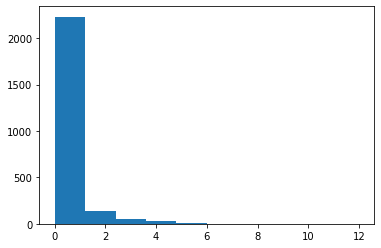

In [ ]:
# Find the list and count of marketing terms in the product text that has 
# a high cosine similarity to the unique/custom word list. 
counts_custom, other_unique_and_comparator_words_custom = extract_similar_words(unique_and_comparator_words_cl, custom_model)
plt.hist(counts_custom.values())
plt.show()

In [ ]:
# Merge the counts back into the main df using a join on product_id.
lotion_df = lotion_df.merge(pd.DataFrame(list(counts_custom.items()),columns = ['product_id','mktg_embedding_counts_custom']), how="inner")

In [ ]:
# Examine the distribution of the number of marketing terms present 
# (based on cosine similarity).
lotion_df['mktg_embedding_counts_custom'].describe()

count    2464.000000
mean        0.409497
std         0.896562
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: mktg_embedding_counts_custom, dtype: float64

In [ ]:
# Examine words in the text that had a high cosine similarity to the unique/comparator word list.
list(other_unique_and_comparator_words_custom)[:min(len(other_unique_and_comparator_words_custom), 25)] 

['premium',
 'littl',
 'new',
 'ultra',
 'differ',
 'singl',
 'less',
 'least',
 'special',
 'far',
 'uniqu']

In [ ]:
# Split products based on the median price to analyze any significant differences 
# in the distribution of the number marketing terms present. 
lower_priced_products = lotion_df[lotion_df['price_unit'] <= cutoff_lotion]
higher_priced_products = lotion_df[lotion_df['price_unit'] > cutoff_lotion]

In [ ]:
# Examine distribution of the number of marketing terms in the text for lower 
# priced products.
lower_priced_products["mktg_embedding_counts_custom"].describe()

count    1232.000000
mean        0.371753
std         0.822973
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: mktg_embedding_counts_custom, dtype: float64

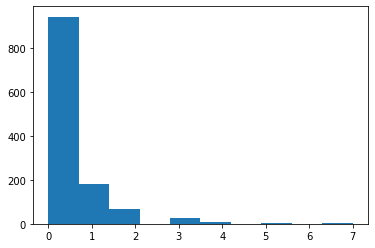

In [ ]:
plt.hist(lower_priced_products["mktg_embedding_counts_custom"])
plt.show()

In [ ]:
# Examine distribution of the number of marketing terms in the text for higher 
# priced products. 
higher_priced_products["mktg_embedding_counts_custom"].describe()

count    1232.000000
mean        0.447240
std         0.963413
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        12.000000
Name: mktg_embedding_counts_custom, dtype: float64

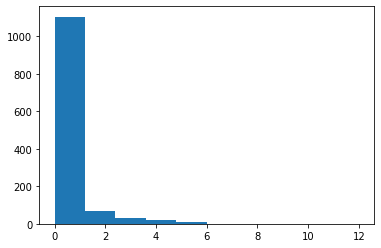

In [ ]:
plt.hist(higher_priced_products["mktg_embedding_counts_custom"])
plt.show()

**2. Pre-trained Glove Embeddings on Unigrams**

The next thing we tried to do to improve on the baseline was to use only unigrams and pre-trained word vectors.

In [ ]:
# Only use unigrams, since bigrams and trigrams joined on '_' won't be in vocab. 
vocab_unigrams = list(itertools.chain.from_iterable(lotion_df["unigrams"]))
print(vocab_unigrams[:10])

['silicon', 'mix', 'silicon', 'mix', 'bambu', 'extract', 'nutrit', 'prod', 'oz', 'ounc']


In [ ]:
# Download pre-trained word vectors.
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [ ]:
# Extract words and the count of those words in each text using cosine similarity to
# the hand curated unique/comparator word list. 
counts_glove, other_unique_and_comparator_words_glove = extract_similar_words(unique_and_comparator_words_cl, glove_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [ ]:
# Merge the counts back into the main df using a join on product_id.
lotion_df = lotion_df.merge(pd.DataFrame(list(counts_glove.items()),columns = ['product_id','mktg_embedding_counts_glov']), how="inner")

In [ ]:
# Examine the distribution of the number of marketing terms present 
# (based on cosine similarity).
lotion_df['mktg_embedding_counts_glov'].describe()

count    2464.000000
mean        9.353896
std        12.983349
min         0.000000
25%         1.000000
50%         5.000000
75%        12.000000
max       108.000000
Name: mktg_embedding_counts_glov, dtype: float64

In [ ]:
# Examine words in the text that had a high cosine similarity to the unique/comparator word list.
list(other_unique_and_comparator_words_glove)[:min(len(other_unique_and_comparator_words_glove), 25)] 

['lot',
 'kind',
 'two',
 'around',
 'half',
 'five',
 'differ',
 'can',
 'sleeker',
 'special',
 'help',
 'play',
 'job',
 'so',
 'bring',
 'dead',
 'current',
 'go',
 'last',
 'million',
 'rather',
 'nine',
 'give',
 'often',
 'come']

In [ ]:
# Split products based on the median price to analyze any significant differences 
# in the distribution of the number marketing terms present. 
lower_priced_products = lotion_df[lotion_df['price_unit'] <= cutoff_lotion]
higher_priced_products = lotion_df[lotion_df['price_unit'] > cutoff_lotion]

In [ ]:
# Examine distribution of the number of marketing terms in the text for lower 
# priced products.
lower_priced_products["mktg_embedding_counts_glov"].describe()

count    1232.000000
mean        9.920455
std        13.303927
min         0.000000
25%         1.000000
50%         5.000000
75%        12.000000
max       102.000000
Name: mktg_embedding_counts_glov, dtype: float64

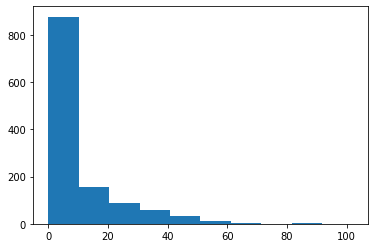

In [ ]:
plt.hist(lower_priced_products["mktg_embedding_counts_glov"])
plt.show()

In [ ]:
# Examine distribution of the number of marketing terms in the text for higher 
# priced products. 
higher_priced_products["mktg_embedding_counts_glov"].describe()

count    1232.000000
mean        8.787338
std        12.634662
min         0.000000
25%         1.000000
50%         4.000000
75%        12.000000
max       108.000000
Name: mktg_embedding_counts_glov, dtype: float64

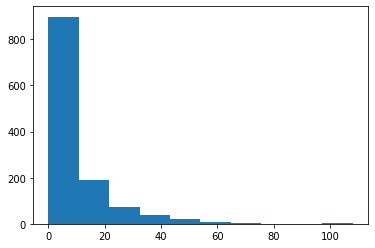

In [ ]:
plt.hist(higher_priced_products["mktg_embedding_counts_glov"])
plt.show()

#### Sentiment Analysis

In [ ]:
# Extract sentiment scores for each text using nltk SentimentIntensityAnalyzer.
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_df = lotion_df["full_text"].apply(sentiment_analyzer.polarity_scores).to_frame()
sentiment_df  = sentiment_df["full_text"].apply(pd.Series)
# Add results to the main dataframe. 
lotion_df["pos"] = sentiment_df["pos"]
lotion_df["neg"] = sentiment_df["neg"]
lotion_df["neu"] = sentiment_df["neu"]
lotion_df["compound"] = sentiment_df["compound"]
# Examine values
lotion_df[["pos","neg","neu","compound"]].head()

,pos,neg,neu,compound
0,0.204,0.044,0.752,0.8689
1,0.075,0.122,0.803,-0.2023
2,0.141,0.120,0.739,0.2263
3,0.000,0.000,1.000,0.0000
4,0.228,0.000,0.772,0.7003


In [ ]:
# Split products based on price. 
lower_priced_products = lotion_df[lotion_df["price_unit"] <= cutoff_lotion] 
higher_priced_products = lotion_df[lotion_df["price_unit"] > cutoff_lotion]

In [ ]:
# Examine sentiment scores for the lower priced products.
lower_priced_products[["pos","neg","neu","compound"]].describe()

,pos,neg,neu,compound
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,0.182294,0.018390,0.799310,0.714098
std,0.102369,0.033779,0.105961,0.376015
min,0.000000,0.000000,0.406000,-0.840200
25%,0.115000,0.000000,0.730000,0.612400
50%,0.193000,0.000000,0.790500,0.896800
75%,0.249000,0.028000,0.866250,0.969000
max,0.594000,0.292000,1.000000,0.998700


In [ ]:
# Examine sentiment scores for the higher priced products. 
higher_priced_products[["pos","neg","neu","compound"]].describe()

,pos,neg,neu,compound
count,1232.000000,1232.000000,1232.00000,1232.000000
mean,0.169657,0.017519,0.81283,0.663473
std,0.105497,0.036884,0.11027,0.393575
min,0.000000,0.000000,0.44000,-0.855500
25%,0.100000,0.000000,0.73575,0.493900
50%,0.173000,0.000000,0.80800,0.848100
75%,0.245000,0.023000,0.88500,0.957100
max,0.560000,0.329000,1.00000,0.999400


### Authenticity

#### Term Frequency - Inverse Document Frequency  
TFIDF gives a score for each token/word in 1 document of documents cominbed into one. For authenticy, we want the words and its tfidf over the whole lower price "document" and higher price "document" (lower_priced_products, higher_priced_products)

In [ ]:
# Create TFIDF function
def tfidf(column, col_name):
  tfIdfVectorizer=TfidfVectorizer(use_idf=True)
  column = column.dropna().tolist()
  text = [' '.join(column)] # makes into a list with one item
    #np.unique(np.hstack(column)).tolist()
  print(text)
  tfIdf = tfIdfVectorizer.fit_transform(text)
  # tfIdf[#] makes it only look at that row - need to fix
  df_name = pd.DataFrame(tfIdf.T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=[col_name])
  df_name = df_name.sort_values(col_name, ascending=False)
  return df_name

In [ ]:
#  Create TFIDF data for lower priced lotions: titles, about, and description
lower_title_tf = tfidf(lower_priced_products.title_cl, col_name='l_title_tfidf')
lower_about_tf = tfidf(lower_priced_products.about_cl, col_name='l_about_tfidf')
lower_desc_tf = tfidf(lower_priced_products.description_cl, col_name='l_desc_tfidf')

#  Create TFIDF data for higher priced lotions: titles, about, and description
higher_title_tf = tfidf(higher_priced_products.title_cl, col_name='h_title_tfidf')
higher_about_tf = tfidf(higher_priced_products.about_cl, col_name='h_about_tfidf')
higher_desc_tf = tfidf(higher_priced_products.description_cl, col_name='h_desc_tfidf')

['silicon mix silicon mix bambu extract nutrit prod oz ounc clay esth prod ex oz refil rainbow research henna hair color prod persian copper oz red avalon organ strengthen peppermint prod prod set ounc scent secret hawaiian ginger prod prod bodi wash ounc tigi bed head colour combat colour goddess prod ounc schwarzkopf bc bonacur smooth shine prod unmanag hair mloz mizani miracl milk leavein prod moistur detangl spray frizzi curli hair design essenti strengthen therapi sulfat free prod oz panten radiant color volum prod oz pack shikai natur volum prod add full textur fine thin hair ounc jason revit vitamin e prod ounc bottl pack panten prov radiant color shine dream care prod prod vibrant shine oz pack tigi bed head like hot heat humid resist prod smooth sooth ounc remi hair style tangl free silk mist leavein prod oz coppola keratin complex clarifi prod ounc bottl aphog prod damag hair fl oz lot cream silk prod standout straight straighter hair creamsilk ml ogx prod brazilian keratin t

In [ ]:
# Create TFIDF dataframe for lower priced products
lower_tf = lower_title_tf.join(lower_about_tf, how='outer')
lower_tf = lower_tf.join(lower_desc_tf, how='outer')
lower_tf['word'] = lower_tf.index
lower_tf.sort_values(by=['l_desc_tfidf'], ascending=False).head(30)

,l_title_tfidf,l_about_tfidf,l_desc_tfidf,word
hair,0.243264,0.748543,0.706335,hair
prod,0.779860,0.341208,0.400664,prod
moistur,0.100680,0.162522,0.164803,moistur
natur,0.069115,0.110209,0.142115,natur
oil,0.089795,0.133427,0.126657,oil
color,0.069115,0.114912,0.123665,color
product,0.005986,0.116675,0.122917,product
use,0.002177,0.104332,0.105713,use
help,0.004898,0.104919,0.101475,help
clean,0.019592,0.106683,0.095242,clean


In [ ]:
# Create TFIDF dataframe for higher priced products
higher_tf = higher_title_tf.join(higher_about_tf, how='outer')
higher_tf = higher_tf.join(higher_desc_tf, how='outer')
higher_tf['word'] = higher_tf.index
higher_tf.sort_values(by=['h_desc_tfidf'], ascending=False).head(30)

,h_title_tfidf,h_about_tfidf,h_desc_tfidf,word
hair,0.245107,0.761475,0.752358,hair
prod,0.758765,0.362374,0.368224,prod
color,0.074598,0.130687,0.136663,color
moistur,0.054350,0.117833,0.124162,moistur
natur,0.058080,0.127627,0.121036,natur
oil,0.060211,0.136808,0.113649,oil
product,0.009058,0.079881,0.105410,product
use,0.002131,0.111099,0.104841,use
help,0.004263,0.097633,0.101432,help
scalp,0.043693,0.092736,0.088931,scalp


In [ ]:
# Create joined TFIDF dataframe
tfidf_joined = lower_tf.merge(higher_tf, how='outer', on ='word')
tfidf_joined = tfidf_joined[['word', 'l_title_tfidf', 'h_title_tfidf',	'l_about_tfidf', 'h_about_tfidf', 'l_desc_tfidf', 'h_desc_tfidf']]
tfidf_joined.sort_values(by='l_title_tfidf', ascending=False) # sort to see, change by accordingly 

,word,l_title_tfidf,h_title_tfidf,l_about_tfidf,h_about_tfidf,l_desc_tfidf,h_desc_tfidf
3580,prod,0.779860,0.758765,0.341208,0.362374,0.400664,0.368224
3275,oz,0.394012,0.474228,0.050843,0.079575,0.076293,0.075009
3246,ounc,0.250883,0.209406,0.023805,0.031830,0.040391,0.034095
2022,hair,0.243264,0.245107,0.748543,0.761475,0.706335,0.752358
1705,fl,0.115918,0.098576,0.008229,0.009488,0.019447,0.011081
...,...,...,...,...,...,...,...
7717,zingib,NaN,NaN,NaN,NaN,NaN,0.000284
7718,zip,NaN,NaN,NaN,0.000306,NaN,NaN
7719,zipper,NaN,NaN,NaN,0.000306,NaN,NaN
7720,zizyphu,NaN,NaN,NaN,NaN,NaN,0.000284


### Health


*   Ingredients from Amazon Products 
*   Toxicity Levels from California Chemicals in Cosmetics Database 



In [ ]:
# Check if ingredient exists in our data
lotion_df[lotion_df['ingredients'].str.contains('retinol', na=False)][["product_title_cl","ingredients"]]

,product_title_cl,ingredients


In [ ]:
lotion_df.ingredients.unique()[0:3]

array([nan,
       'Lawsonia inermis (red henna), indigofereae (black henna) and cassia obovata (neutral henna).',
       'Honey, Oat, Vitamin E'], dtype=object)

In [ ]:
toxic_chem_li = ['titanium dioxide',
 'distillates',
 'estragole',
 'cocamide diethanolamine',
 'toluene',
 'chromium',
 'retinol',
 'retinol/retinyl esters',
 'vitamin a',
 'vitamin a palmitate',
 'butylated hydroxyanisole',
 'coffea arabica extract',
 'lauramide diethanolamine',
 'silica',
 'carbon black',
 'genistein',
 'progesterone',
 '2,4-hexadienal',
 'methyleugenol',
 'carbon-black extracts',
 'retinyl palmitate',
 'o-phenylphenol',
 'acrylamide',
 'formaldehyde',
 'ginkgo biloba extract',
 'mica',
 'ethylene glycol',
 'acetic acid',
 'ethyl acrylate',
 'trade secret',
 'methanol',
 'mineral oils',
 'diethanolamine',
 'tea-lauryl sulfate',
 'retinyl acetate',
 'lead acetate',
 'talc',
 'triethanolamine',
 'o-phenylenediamine and its salts',
 'safrole',
 'styrene',
 'acetaldehyde',
 'cocamide dea',
 '1,4-dioxane',
 'arsenic',
 'dichloroacetic acid',
 'ethylene oxide',
 'lead',
 'dichloromethane',
 'benzene',
 'benzyl chloride',
 'n-nitrosodimethylamine',
 'propylene oxide',
 'methyl chloride',
 'cadmium and cadmium compounds',
 'n-methylpyrrolidone',
 'di-n-butyl phthalate',
 'coal tars',
 'all-trans retinoic acid',
 'quinoline and its strong acid salts',
 'methylene glycol',
 'benzophenone',
 'cocamide',
 'lauramide dea',
 'aloe vera',
 'musk xylene',
 'aspirin',
 'coal tar',
 'benzophenone-3',
 'quartz',
 'talc containing asbestiform fibers',
 'sodium bromate',
 'phenacetin',
 'mercury and mercury compounds',
 'p-aminodiphenylamine',
 'permethrin',
 'acetylsalicylic acid',
 'coal tar extract',
 'selenium sulfide',
 'oil orange ss',
 'spironolactone',
 'nickel',
 'caffeic acid',
 'cocamide mea',
 'cosmetic talc',
 'c.i. acid red 114',
 'caffeine',
 'benzophenone-4',
 'ethanol in alcoholic beverages',
 'coffee extract',
 'retinol palmitate',
 'coffee bean extract',
 'propylene glycol mono-t-butyl ether',
 'avobenzone',
 'coal tar solution',
 'pulegone',
 'beta-myrcene',
 '2,2-bis(bromomethyl)-1,3-propanediol',
 'benzo[a]pyrene',
 'benz[a]anthracene',
 'extract of coffee bean',
 'goldenseal root powder',
 'isopropyl alcohol manufacture using strong acids',
 '2-propyleneacrolein',
 'n,n-dimethyl-p-toluidine',
 'formaldehyde solution',
 'n-nitrosodiethanolamine',
 'benzophenone-2',
 'vinyl acetate',
 'trichloroacetic acid',
 'phenacemide',
 'polygeenan',
 'diethanolamides of the fatty acids of coconut oil',
 'bisphenol a',
 'hydrous magnesium silicate']

In [ ]:
# If ingredients contain toxic ingredient, label how many, else 0. 
def check_toxic(ing):
  counter = 0
  for i in toxic_chem_li:
    if i in ing.lower().split(', '): 
      counter += 1
  
  return counter

In [ ]:
# If a product  contain toxic ingredients, create a list of them joined on |.
def check_toxic_ingredient(ing):
  li = []
  for i in toxic_chem_li:
    if i in ing.lower().split(', '): 
      li.append(i)
  return '|'.join(li)

In [ ]:
# Retrieve count of toxic ingredients.
lotion_df['toxic_count'] = lotion_df['ingredients'].apply(lambda x: check_toxic(x) if pd.notnull(x) else None)

In [ ]:
# Retrieve list of toxic ingredients. 
lotion_df['toxic_ing'] = lotion_df['ingredients'].apply(lambda x: check_toxic_ingredient(x) if pd.notnull(x) else None)

In [ ]:
# Split products based on price. 
lower_priced_products = lotion_df[lotion_df["price_unit"] <= cutoff_lotion] 
higher_priced_products = lotion_df[lotion_df["price_unit"] > cutoff_lotion]

In [ ]:
# Examine distribution of toxic ingredients for lower priced products. 
lower_priced_products["toxic_count"].describe() 

count    508.000000
mean       0.250000
std        0.542567
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: toxic_count, dtype: float64

In [ ]:
# Examine distribution of toxic ingredients for higher  priced products.
higher_priced_products["toxic_count"].describe() 

count    453.000000
mean       0.253863
std        0.523361
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: toxic_count, dtype: float64

## Modeling

In [ ]:
# Truncate text to a max length of 100.
def truncate_or_fill(text):
  if len(text.split()) >= 100:
    return ' '.join(text.split()[:100])
  return text

In [ ]:
# Truncate all text to a max length of 100
lotion_df["full_text_trunc"] = lotion_df["full_text"].apply(truncate_or_fill)

#### Neural Network (Definition) 

Used for the baseline and the improvement.[link text](https://)

In [ ]:
# Run a 3 layer Dense Neural Network with Dropout and Relu activation.
# Examine results interms of Mean Squared Error. 
def run_model(input_dims, train_features, train_labels, test_features, test_labels, epochs_):
  model = tf.keras.models.Sequential()
  model.add( tf.keras.layers.Dense(64, activation='relu',input_shape=input_dims))
  model.add( tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add( tf.keras.layers.Dense(1))

  loss_fn = tf.keras.losses.MeanAbsoluteError()

  model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['mse'])  
  
  history = model.fit(train_features,train_labels, epochs=epochs_)
  results = model.evaluate(test_features, test_labels)
  print("Mean Absolute Error, Mean Squared Error ", results)

### Train Test Split

In [ ]:
# Split data into train and test.
random_df = pd.DataFrame(np.random.randn(lotion_df["full_text_trunc"].shape[0]))
mask = np.random.rand(len(random_df)) < 0.8
train_features = lotion_df[mask]
train_labels = lotion_df["price_unit"][mask].fillna(0)
test_features = lotion_df[~mask]
test_labels = lotion_df["price_unit"][~mask].fillna(0)

In [ ]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1977, 29)
(1977,)
(487, 29)
(487,)


### Baseline
Run a Neural Network with features computed during the Freedman and Jurafsky Analysis

In [ ]:
# Scale a dataframe column
def scale_data(data):
  min_max_scaler = preprocessing.StandardScaler()
  data_scaled = min_max_scaler.fit_transform(data)
  return pd.DataFrame(data_scaled)

In [ ]:
lotion_df["marketing_term_count_scaled"] = scale_data((lotion_df["marketing_term_count_raw"]+1).values.reshape(-1,1))
lotion_df["flesch_kincaid_grade_scaled"] = scale_data((lotion_df["flesch_kincaid_grade"]).values.reshape(-1,1))
lotion_df["reading_ease_scaled"] = scale_data((lotion_df["reading_ease"]).values.reshape(-1,1))
lotion_df["lexicon_count_scaled"] = scale_data((lotion_df["lexicon_count"]).values.reshape(-1,1))
lotion_df["mktg_embedding_counts_glov_scaled"] = scale_data((lotion_df["mktg_embedding_counts_glov"]).values.reshape(-1,1))
lotion_df["compound_scaled"] = scale_data((lotion_df["compound"]).values.reshape(-1,1))
lotion_df["toxic_count_scaled"] = scale_data((lotion_df["toxic_count"]).values.reshape(-1,1))

In [ ]:
# Scaled Data
# Mean Absolute Error, Mean Squared Error  [6.7269392013549805, 275.2937316894531]
train = lotion_df[["marketing_term_count_scaled" , "flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "compound_scaled","toxic_count_scaled"]][mask]
test = lotion_df[["marketing_term_count_scaled" , "flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "compound_scaled","toxic_count_scaled"]][~mask]

# Results of using Unscaled Features. 
# Mean Absolute Error, Mean Squared Error  [6.72703218460083, 275.4627685546875]
train = lotion_df[["marketing_term_count_raw" , "flesch_kincaid_grade" , "reading_ease" , "lexicon_count" , "mktg_embedding_counts_glov" , "compound","toxic_count"]][mask]
test = lotion_df[["marketing_term_count_raw" , "flesch_kincaid_grade" , "reading_ease" , "lexicon_count" , "mktg_embedding_counts_glov" , "compound","toxic_count"]][~mask]

# Scaled and neu instead of compount
# Mean Absolute Error, Mean Squared Error  [6.727107048034668, 275.5451965332031]
train = lotion_df[[ "marketing_term_count_scaled" ,"flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled","toxic_count_scaled" , "neu"]][mask]
test = lotion_df[["marketing_term_count_scaled" ,"flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "neu","toxic_count_scaled"]][~mask]

In [ ]:
run_model((train.shape[1],), train, train_labels, test, test_labels, 200)

Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 2.4400 - mse: 15.2492
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 2.0277 - mse: 15.4984
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5025 - mse: 10.2329
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4219 - mse: 9.0435
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4706 - mse: 10.2324
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4448 - mse: 9.0356
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4956 - mse: 10.8878
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3961 - mse: 9.0128
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3438 - mse: 7.5662
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4611 - mse: 9.1680
Epoch 11/200
62/62 [==============================] - 

### Improvement 
Use Embeddings and pass them through a Neural Net as well as a Convolutional Neural Net.


#### ELMO - Contextualized Word Embeddings

In [ ]:
  elmo_embeddings_train_path_lotion = '/content/gdrive/MyDrive/266/final/data/elmo_embeddings_train_lotion.npy'
  elmo_embedding_test_path_lotion = '/content/gdrive/MyDrive/266/final/data/elmo_embeddings_test_lotion.npy'

In [ ]:
train_features.values

array([[0, 'B00GYDKEOE',
        'silicon mix bamboo nutritive shampoo treatment 16oz set', ...,
        nan, None,
        "silicon mix silicon mix bambu extract nutrit prod oz ounc nutrit prod bamboo extract regener nourish vitamin e c f carthamu oil almond oil improv health beauti hair hair type includ natur process hair follow silicon mix bambu treatment good result work great brittl dull hair free residu improv silicon mix bambu treatment ' s effici "],
       [1, 'B001I7UL8A', 'clay esthe shampoo ex oz refill', ..., nan,
        None,
        'clay esth prod ex oz refil improv health scalp hair keep scalp healthi remov dirt excess oil sweat caus clog pore increa moistur soft loosen tension caus scalp relax leav hair moistur soft healthi'],
       [2, 'B0009EXOO6',
        'sexy hair concepts healthy sexy hair soy triwheat leavein conditioner oz',
        ..., nan, None,
        'healthi sexi hair triwheat leav prod oz  power combin soy cocoa work synergist perfectli care hair pro

In [ ]:
def create_and_save_elmo_embeddings(elmo_embeddings_train_path_, elmo_embedding_test_path_):
  # Load pre-trained ELMO model
  elmo = hub.load("https://tfhub.dev/google/elmo/3")

  # NO BATCH - crashes
  # tf_constants = tf.constant(train_features, dtype = tf.string) 
  # elmo_embeddings = elmo.signatures["default"](tf_constants)["default"]

  # BATCH
  # Training Embeddings
  tf_constants = tf.constant(train_features["full_text_trunc"], dtype = tf.string) 
  batch_size = 200
  embeddings = []
  for index in (np.arange(0, len(tf_constants), batch_size)):
    batch_embeddings = elmo.signatures["default"](tf_constants[index:index+batch_size])["default"]
    embeddings.append(batch_embeddings)

  elmo_embeddings = tf.concat(embeddings, axis=0)

  # Test Embeddings 
  tf_constants_test = tf.constant(test_features["full_text_trunc"], dtype = tf.string)
  embeddings_test = []
  for index in (np.arange(0, len(tf_constants_test), batch_size)):
    batch_embeddings = elmo.signatures["default"](tf_constants_test[index:index+batch_size])["default"]
    embeddings_test.append(batch_embeddings)

  elmo_embeddings_test = tf.concat(embeddings_test, axis=0)

  # Store embeddings so its faster to load and use them later
  np.save(elmo_embeddings_train_path_, elmo_embeddings)
  np.save(elmo_embedding_test_path_, elmo_embeddings_test)


create_and_save_elmo_embeddings(elmo_embeddings_train_path_lotion,elmo_embedding_test_path_lotion)

In [ ]:
# Load pre-saved elmo word embeddings 
elmo_embeddings_lotion = np.load(elmo_embeddings_train_path_lotion)
elmo_embeddings_lotion_test = np.load(elmo_embedding_test_path_lotion)

In [ ]:
print("elmo_embeddings_lotion shape: ", elmo_embeddings_lotion.shape)
print("elmo_embeddings_lotion_test shape: ", elmo_embeddings_lotion_test.shape)

elmo_embeddings_lotion shape:  (1977, 1024)
elmo_embeddings_lotion_test shape:  (487, 1024)


#### BERT (Variations) Embeddings
Semi-Adapted from [Source](https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb)

In [ ]:
def create_and_save_bert_embeddings(text, embeddings_path, bert_type="distilbert", batch_size=100):

  # Load Pre-Trained BERT Model 
  if bert_type == "distilbert":
    model_class, tokenizer_class, pretrained_weights = (transformer.DistilBertModel, transformer.DistilBertTokenizer, 'distilbert-base-uncased')
  elif bert_type == "roberta":
    model_class, tokenizer_class, pretrained_weights = (transformer.RobertaModel, transformer.RobertaTokenizer, 'roberta-base')
  else:
    model_class, tokenizer_class, pretrained_weights = (transformer.BertModel, transformer.BertTokenizer, 'bert-base-uncased')

  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  # Extract embeddings in batches
  embeddings = []
  for index in tqdm(np.arange(0, len(text["full_text_trunc"]), batch_size)):
    batch = text["full_text_trunc"][index:index+batch_size]
    tokenized = batch.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Add padding so all inputs are the same size 
    max_len = 0
    for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Apply attention mask to ignore padding 
    attention_mask = np.where(padded != 0, 1, 0)

    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
      last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Retrieve the representation of the entire sentence 
    embeddings.append(last_hidden_states[0][:,0,:].numpy())

  # Since we did batches, concatenate into a single embeeddings list 
  embeddings = np.concatenate(embeddings, 0)  # N, 768
  # Save to file 
  np.save(embeddings_path,embeddings)

 **DistilBERT**

In [ ]:
distilbert_embeddings_train_path_lotion = "/content/gdrive/MyDrive/266/final/data/distilbert_embeddings_train_lotion.npy"
distilbert_embeddings_test_path_lotion =  "/content/gdrive/MyDrive/266/final/data/distilbert_embeddings_test_lotion.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, distilbert_embeddings_train_path_lotion  , bert_type="distilbert")
create_and_save_bert_embeddings(test_features, distilbert_embeddings_test_path_lotion, bert_type="distilbert")

100%|██████████| 5/5 [01:00<00:00, 12.09s/it]


In [ ]:
# Load pre-saved DistilBERT word embeddings 
distilbert_embeddings_lotion = np.load(distilbert_embeddings_train_path_lotion)
distilbert_embeddings_lotion_test = np.load(distilbert_embeddings_test_path_lotion)

In [ ]:
print("distilbert_embeddings_lotion shape: ", distilbert_embeddings_lotion.shape)
print("distilbert_embeddings_lotion_test shape: ", distilbert_embeddings_lotion_test.shape)

distilbert_embeddings_lotion shape:  (1977, 768)
distilbert_embeddings_lotion_test shape:  (487, 768)


 **RoBERTa**

In [ ]:
roberta_embeddings_train_path_lotion = "/content/gdrive/MyDrive/266/final/data/roberta_embeddings_train_lotion.npy"
roberta_embeddings_test_path_lotion =  "/content/gdrive/MyDrive/266/final/data/roberta_embeddings_test_lotion.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, roberta_embeddings_train_path_lotion  , bert_type="roberta")
create_and_save_bert_embeddings(test_features, roberta_embeddings_test_path_lotion, bert_type="roberta")

100%|██████████| 5/5 [01:45<00:00, 21.19s/it]


In [ ]:
# Load pre-saved RoBERTa word embeddings 
roberta_embeddings_lotion = np.load(roberta_embeddings_train_path_lotion)
roberta_embeddings_lotion_test = np.load(roberta_embeddings_test_path_lotion)

In [ ]:
print("roberta_embeddings_lotion shape: ", roberta_embeddings_lotion.shape)
print("roberta_embeddings_lotion_test shape: ", roberta_embeddings_lotion_test.shape)

roberta_embeddings_lotion shape:  (1977, 768)
roberta_embeddings_lotion_test shape:  (487, 768)


**BERT (original)**

In [ ]:
bert_embeddings_train_path_lotion = "/content/gdrive/MyDrive/266/final/data/bert_embeddings_train_lotion.npy"
bert_embeddings_test_path_lotion =  "/content/gdrive/MyDrive/266/final/data/bert_embeddings_test_lotion.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, bert_embeddings_train_path_lotion  , bert_type="bert")
create_and_save_bert_embeddings(test_features, bert_embeddings_test_path_lotion, bert_type="bert")

100%|██████████| 5/5 [02:01<00:00, 24.33s/it]


In [ ]:
# Load pre-saved RoBERTa word embeddings 
bert_embeddings_lotion = np.load(bert_embeddings_train_path_lotion)
bert_embeddings_lotion_test = np.load(bert_embeddings_test_path_lotion)

In [ ]:
print("bert_embeddings_lotion shape: ", bert_embeddings_lotion.shape)
print("bert_embeddings_lotion_test shape: ", bert_embeddings_lotion_test.shape)

bert_embeddings_lotion shape:  (1977, 768)
bert_embeddings_lotion_test shape:  (487, 768)


### Neural Network - Run for Improvement

In [ ]:
# ELMO
run_model((1024,), elmo_embeddings_lotion, train_labels, elmo_embeddings_lotion_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [11.123788833618164, 4236.31884765625]
"""

Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 1.5473 - mse: 9.3098
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3872 - mse: 7.8063
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6155 - mse: 11.4117
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3370 - mse: 7.7866
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3573 - mse: 7.5294
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3978 - mse: 8.4461
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3397 - mse: 8.4036
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3573 - mse: 8.9310
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3913 - mse: 8.9624
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4076 - mse: 8.8540
Epoch 11/200
62/62 [==============================] - 0s 2

'\nMean Absolute Error, Mean Squared Error  [11.123788833618164, 4236.31884765625]\n'

In [ ]:
# DistilBERT
run_model((768,), distilbert_embeddings_lotion, train_labels, distilbert_embeddings_lotion_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [6.725437641143799, 338.0096740722656]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6234 - mse: 8.6808
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5028 - mse: 10.5511
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3653 - mse: 8.7254
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4152 - mse: 8.8881
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4287 - mse: 9.1792
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4755 - mse: 9.4612
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3899 - mse: 8.1886
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3481 - mse: 8.0312
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3980 - mse: 9.8459
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3723 - mse: 8.2716
Epoch 11/200
62/62 [==============================] - 0s 2

'\nMean Absolute Error, Mean Squared Error  [6.725437641143799, 338.0096740722656]\n'

In [ ]:
# RoBERTa
run_model((768,), roberta_embeddings_lotion, train_labels, roberta_embeddings_lotion_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [6.730209827423096, 325.2977600097656]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.8138 - mse: 12.6301
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3500 - mse: 7.1661
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4314 - mse: 8.5962
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4618 - mse: 9.4439
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3291 - mse: 7.2046
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4178 - mse: 9.0179
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3532 - mse: 8.0313
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3350 - mse: 8.3150
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3957 - mse: 9.3645
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3641 - mse: 8.9467
Epoch 11/200
62/62 [==============================] - 0s 2

'\nMean Absolute Error, Mean Squared Error  [6.730209827423096, 325.2977600097656]\n'

In [ ]:
# BERT
run_model((768,), bert_embeddings_lotion, train_labels, bert_embeddings_lotion_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [5.8421783447265625, 309.8191223144531]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6878 - mse: 9.2238
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4326 - mse: 8.0591
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3536 - mse: 8.3371
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3021 - mse: 6.5223
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2780 - mse: 6.8436
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3567 - mse: 8.3212
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3289 - mse: 8.6539
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2758 - mse: 7.3302
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3053 - mse: 7.7325
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.1910 - mse: 6.3230
Epoch 11/200
62/62 [==============================] - 0s 2m

'\nMean Absolute Error, Mean Squared Error  [5.8421783447265625, 309.8191223144531]\n'

### Convolutional Neural Network

In [ ]:
def train_cnn(embeddings_train, train_labels, epochs=100):    
  # Specify model hyperparameters.
    num_filters = [4, 4, 4, 4]
    kernel_sizes= [4, 2, 3, 4]
    dense_layer_dims = [64,64]
    dropout_rate = 0.85
 
    # Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
    word_embeddings = keras.layers.Input(shape=(embeddings_train.shape[1],1))

    # Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(word_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    # Concat the feature maps from each different size.
    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # Add dropout to improve generalization
    h = keras.layers.Dropout(rate=dropout_rate)(h)

    # A fully connected layer for each dense layer dimension in dense_layer_dims.
    for dense_layer_dimension in dense_layer_dims:
        keras.layers.Dense(dense_layer_dimension, activation='relu')

    prediction = keras.layers.Dense(1)(h)

    model = keras.Model(inputs=word_embeddings, outputs=prediction)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error',  
                  metrics=['mse'])        
    model.reset_states()
    model.fit(embeddings_train, train_labels, epochs=epochs)
    return model

In [ ]:
# Explore Hyperparameters 
def explore_hyper_parameters():
  dropout_rates_list = []
  num_filters_list = []
  kernel_sizes_list = []
  results_list = []
  for i in range(10):
      print("Run: ", i)
      dropout_rate = random.uniform(0, 1)
      num = np.random.randint(3,5)
      num_filters = [np.random.randint(3,8)]*num
      kernel_sizes = []
      for i in range(num):
        kernel_sizes.append(np.random.randint(2,5))
      print(num, num_filters, kernel_sizes)
      model = train_cnn(bert_embeddings_hair,train_labels, dropout_rate, kernel_sizes, num_filters)
      results = model.evaluate(bert_embeddings_hair_test, test_labels)
      dropout_rates_list.append(dropout_rate)
      num_filters_list.append(num_filters)
      kernel_sizes_list.append(kernel_sizes)
      results_list.append(results)

      
  for i in range(30):
    print(dropout_rates_list[i],num_filters_list[i],kernel_sizes_list[i],results_list[i])

In [ ]:
type(train_labels)

pandas.core.series.Series

In [ ]:
# ELMO
cnn = train_cnn(elmo_embeddings_lotion, np.array(train_labels))
results = cnn.evaluate(elmo_embeddings_lotion_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.4698753356933594, 9.138339042663574]
"""

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 3.3254 - mse: 20.2459
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 2.7130 - mse: 14.9390
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 2.3948 - mse: 13.5749
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 2.1293 - mse: 12.1197
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 1.9822 - mse: 11.3006
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 1.7590 - mse: 9.3315
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 1.8053 - mse: 10.2902
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 1.8461 - mse: 14.6861
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 1.6803 - mse: 10.6584
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 1.6155 - mse: 8.9375
Epoch 11/100
62/62 [==============================]

'\nMean Absolute Error, Mean Squared Error:  [1.4698753356933594, 9.138339042663574]\n'

In [ ]:
# DistilBERT
cnn = train_cnn(distilbert_embeddings_lotion, train_labels)
results = cnn.evaluate(distilbert_embeddings_lotion_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.4674744606018066, 9.114583015441895]
"""

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 6.9203 - mse: 81.0167
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 5.6024 - mse: 52.7964
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 4.7530 - mse: 39.3904
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 3.8360 - mse: 26.3953
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 3.0981 - mse: 18.6499
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 2.6327 - mse: 14.4721
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 2.3534 - mse: 12.5267
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 2.0447 - mse: 10.4381
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 1.8848 - mse: 10.8266
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 1.8816 - mse: 12.4370
Epoch 11/100
62/62 [=============================

'\nMean Absolute Error, Mean Squared Error:  [5.8317155838012695, 328.1436767578125]\n'

In [ ]:
# RoBERTa
cnn = train_cnn(roberta_embeddings_lotion, train_labels)
results = cnn.evaluate(roberta_embeddings_lotion_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.471461534500122, 9.153165817260742]
"""

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 9.3051 - mse: 144.6431
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 7.6285 - mse: 94.0152
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 5.5970 - mse: 53.9058
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 4.6246 - mse: 35.6795
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 3.4907 - mse: 22.8704
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 2.8297 - mse: 15.8330
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 2.4225 - mse: 13.3116
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 2.1226 - mse: 11.8539
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 1.8570 - mse: 11.2842
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 1.6813 - mse: 9.7157
Epoch 11/100
62/62 [=============================

'\nMean Absolute Error, Mean Squared Error:  [5.817124843597412, 328.12060546875]\n'

In [ ]:
# BERT
cnn = train_cnn(bert_embeddings_lotion, train_labels)
results = cnn.evaluate(bert_embeddings_lotion_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.47007417678833, 9.10583782196045]
"""

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 8.1541 - mse: 113.9964
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 6.5697 - mse: 74.5100
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 4.9807 - mse: 44.5814
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 4.1455 - mse: 30.4882
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 3.2063 - mse: 19.3889
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 2.5880 - mse: 13.4496
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 2.3110 - mse: 12.3810
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 2.2133 - mse: 12.7164
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9326 - mse: 9.7864
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 1.8156 - mse: 10.3183
Epoch 11/100
62/62 [=============================

'\nMean Absolute Error, Mean Squared Error:  [5.816550254821777, 328.2109375]\n'

# Hair Product Analysis

## Data Manipulation

In [ ]:
# Reduce dataset to only columns we're interested in. 
hair_df = hair_df[["product_id", "product_title_cl", 'title_cl', 'about_cl', 'description_cl', "price_cl", 'price_unit', 'ingredients', "category", "full_text", "title"]]
# Remove all products where the unit price is NAN
hair_df = hair_df[hair_df['price_unit'].notna()]
# Reset the index to ensure linearity. 
hair_df = hair_df.reset_index()

In [ ]:
hair_df.shape

(2487, 12)

Remove Outliers: [Source](https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python)

In [ ]:
# Remove Outliers 
z_scores = stats.zscore(hair_df["price_unit"].values)
abs_z_scores = np.abs(z_scores).reshape(-1,1)
filtered_entries = (abs_z_scores < 1.7).all(axis=1)
hair_df = hair_df[filtered_entries]

In [ ]:
# Number of unique product_ids.  
len(hair_df.product_id.unique())

2464

In [ ]:
# Examine the sub-categories in the hair dataset. 
hair_df["category"].value_counts()

shampoo        1496
conditioner     968
Name: category, dtype: int64

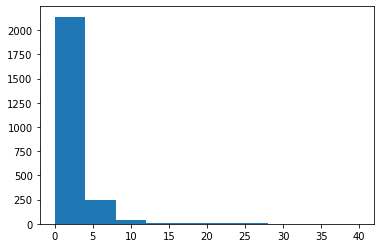

In [ ]:
# Examine the distribution of price per unit (ounces).
plt.hist(hair_df['price_unit'], range=[0,40])
plt.show()

In [ ]:
hair_df["price_unit"].describe()

count    2464.000000
mean        2.489824
std         2.857140
min         0.017240
25%         1.081667
50%         1.720714
75%         2.833885
max        32.950000
Name: price_unit, dtype: float64

In [ ]:
# Value to split products into lower and higher priced hair products
cutoff_hair = hair_df["price_unit"].median()
cutoff_hair

1.7207142857142856

## Freedman and Jurafsky Analysis (Scaled)


### Falutin

Flesch Reading Score and Grade Level

In [ ]:
# The flesch kincaid grade indicates the grade that a student would be able to read
# the text. For example, a 9.3 means a ninth grader could read the text. 
hair_df["flesch_kincaid_grade"] = hair_df["full_text"].apply(textstat.flesch_kincaid_grade)

# The flesch read ease score has no lower bound, but has an upper bound of 121.22. 
# The lower the score is, the harder the text is to read. 
hair_df["reading_ease"] = hair_df["full_text"].apply(textstat.flesch_reading_ease)

Number of Words

In [ ]:
# Count the number of words present in the text (does not include punctuation by default).
hair_df["lexicon_count"] = hair_df["full_text"].apply(textstat.lexicon_count)

Word Commonality

In [ ]:
# Raw count of marketing terms present. 
hair_df["marketing_term_count_raw"] = hair_df["full_text"].apply(count_marketing_terms)

In [ ]:
# Examine falutin variables (as a whole).
hair_df[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,2464.000000,2464.000000,2464.000000,2464.000000
mean,33.324107,-2.362658,79.426136,8.640828
std,27.288936,73.259133,69.118892,8.756718
min,0.900000,-634.630000,5.000000,0.000000
25%,15.800000,-23.260000,35.000000,3.000000
50%,25.100000,17.340000,58.000000,6.000000
75%,40.400000,45.090000,98.250000,12.000000
max,276.700000,104.640000,704.000000,83.000000


In [ ]:
# Split dataset based on the median of the price. 
lower_priced_products = hair_df[hair_df['price_unit'] <= cutoff_hair]
higher_priced_products = hair_df[hair_df['price_unit'] > cutoff_hair]

In [ ]:
# Examine distribution of falutin variables for lower priced products. 
lower_priced_products[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,34.793344,-6.378782,83.088474,9.103896
std,27.358890,73.396034,69.307268,8.947300
min,2.900000,-379.870000,7.000000,0.000000
25%,16.600000,-28.000000,37.000000,3.000000
50%,26.300000,14.980000,59.000000,7.000000
75%,42.300000,41.370000,103.000000,12.000000
max,178.800000,97.540000,453.000000,55.000000


In [ ]:
# Examine distribution of falutin variabels for higher priced products. 
higher_priced_products[["flesch_kincaid_grade","reading_ease", "lexicon_count","marketing_term_count_raw" ]].describe()

,flesch_kincaid_grade,reading_ease,lexicon_count,marketing_term_count_raw
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,31.854870,1.653466,75.763799,8.177760
std,27.150457,72.930778,68.763208,8.540441
min,0.900000,-634.630000,5.000000,0.000000
25%,14.600000,-18.870000,33.000000,2.000000
50%,23.600000,20.050000,55.000000,5.500000
75%,38.875000,48.132500,95.000000,11.000000
max,276.700000,104.640000,704.000000,83.000000


### Distinction

#### Unique and Comparator Words: Baseline

As a baseline anlaysis, we hand-curated a list of words that indicate "uniqueness". This feature will just indicate the number of unique words present in the title.

In [ ]:
hair_df["unique_word_count_basic"] = hair_df["full_text"].apply(count_unique_and_comparator_words)
hair_df["unique_word_count_basic"].describe()

count    2464.000000
mean        0.313718
std         0.614646
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: unique_word_count_basic, dtype: float64

This method provided next to no signal. 

#### Unique and Comparator Words: Improvement

We tried two different things to improve this signal. 

**1. Unigrams, Bigrams, Trigrams Using a Custom Word2Vec Model**

First, we extracted unigrams, bigrams and trigrams. We combined the bigrams and trigrams by underscores to create unique unigrams capturing the two or three words. Then we created our own embeddings using a custom Word2Vec model. 

In [ ]:
# Extract unigrams, bigrams and trigrams. 
# Think we should remove prod from unigram/bigram/trigram.
hair_df["unigrams"] = hair_df["full_text"].apply(lambda x: np.array(str.split(x)))
hair_df["bigrams"] = hair_df["unigrams"].apply(nltk.bigrams).apply(list).apply(connect_by_underscore)
hair_df["trigrams"] = hair_df["unigrams"].apply(nltk.trigrams).apply(list).apply(connect_by_underscore)

In [ ]:
# Examine Unigrams
hair_df["unigrams"][:5]

0    [silicon, mix, silicon, mix, bambu, extract, nutrit, prod, oz, ounc, nutrit, prod, bamboo, extract, regener, nourish, vitamin, e, c, f, carthamu, oil, almond, oil, improv, health, beauti, hair, hair, type, includ, natur, process, hair, follow, silicon, mix, bambu, treatment, good, result, work, great, brittl, dull, hair, free, residu, improv, silicon, mix, bambu, treatment, ', s, effici]
1                                                                                                                                                                   [clay, esth, prod, ex, oz, refil, improv, health, scalp, hair, keep, scalp, healthi, remov, dirt, excess, oil, sweat, caus, clog, pore, increa, moistur, soft, loosen, tension, caus, scalp, relax, leav, hair, moistur, soft, healthi]
2                                                                                                                      [healthi, sexi, hair, triwheat, leav, prod, oz, power, combin, soy, cocoa, work, synergis

In [ ]:
# Create a single vocabulary out of all unigrams, bigrams and trigrams.
vocab_unigrams_bigrams_trigrams = list(itertools.chain.from_iterable(list([hair_df["unigrams"].values,hair_df["bigrams"].values,hair_df["trigrams"].values])))
vocab_unigrams_bigrams_trigrams = list(itertools.chain.from_iterable(vocab_unigrams_bigrams_trigrams))
print(vocab_unigrams_bigrams_trigrams[-5:])

['free_prod_tec', 'prod_tec_itali', 'tec_itali_unisex', 'itali_unisex_oz', 'unisex_oz_shampoo']


In [ ]:
# Create word vectors for the vocabulary using Word2Vec.
custom_model = gensim.models.Word2Vec([vocab_unigrams_bigrams_trigrams])
custom_model.save('custom.embedding')
custom_model = gensim.models.Word2Vec.load('custom.embedding')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


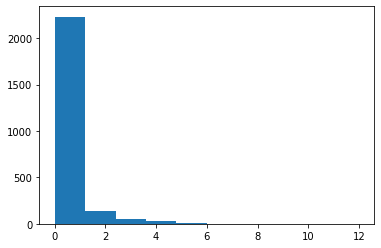

In [ ]:
# Find the list and count of marketing terms in the product text that has 
# a high cosine similarity to the unique/custom word list. 
counts_custom, other_unique_and_comparator_words_custom = extract_similar_words(unique_and_comparator_words_cl, custom_model)
plt.hist(counts_custom.values())
plt.show()

In [ ]:
# Merge the counts back into the main df using a join on product_id.
hair_df = hair_df.merge(pd.DataFrame(list(counts_custom.items()),columns = ['product_id','mktg_embedding_counts_custom']), how="inner")

In [ ]:
# Examine the distribution of the number of marketing terms present 
# (based on cosine similarity).
hair_df['mktg_embedding_counts_custom'].describe()

count    2464.000000
mean        0.409497
std         0.896562
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: mktg_embedding_counts_custom, dtype: float64

In [ ]:
# Examine words in the text that had a high cosine similarity to the unique/comparator word list.
list(other_unique_and_comparator_words_custom)[:min(len(other_unique_and_comparator_words_custom), 25)] 

['premium',
 'littl',
 'new',
 'ultra',
 'differ',
 'singl',
 'less',
 'least',
 'special',
 'far',
 'uniqu']

In [ ]:
# Split products based on the median price to analyze any significant differences 
# in the distribution of the number marketing terms present. 
lower_priced_products = hair_df[hair_df['price_unit'] <= cutoff_hair]
higher_priced_products = hair_df[hair_df['price_unit'] > cutoff_hair]

In [ ]:
# Examine distribution of the number of marketing terms in the text for lower 
# priced products.
lower_priced_products["mktg_embedding_counts_custom"].describe()

count    1232.000000
mean        0.371753
std         0.822973
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: mktg_embedding_counts_custom, dtype: float64

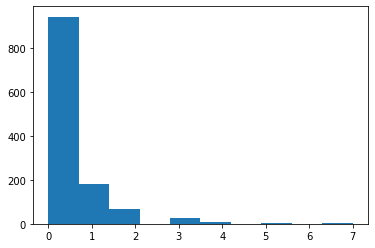

In [ ]:
plt.hist(lower_priced_products["mktg_embedding_counts_custom"])
plt.show()

In [ ]:
# Examine distribution of the number of marketing terms in the text for higher 
# priced products. 
higher_priced_products["mktg_embedding_counts_custom"].describe()

count    1232.000000
mean        0.447240
std         0.963413
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        12.000000
Name: mktg_embedding_counts_custom, dtype: float64

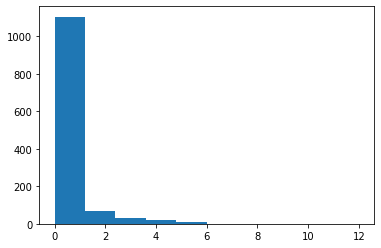

In [ ]:
plt.hist(higher_priced_products["mktg_embedding_counts_custom"])
plt.show()

**2. Pre-trained Glove Embeddings on Unigrams**

The next thing we tried to do to improve on the baseline was to use only unigrams and pre-trained word vectors.

In [ ]:
# Only use unigrams, since bigrams and trigrams joined on '_' won't be in vocab. 
vocab_unigrams = list(itertools.chain.from_iterable(hair_df["unigrams"]))
print(vocab_unigrams[:10])

['silicon', 'mix', 'silicon', 'mix', 'bambu', 'extract', 'nutrit', 'prod', 'oz', 'ounc']


In [ ]:
# Extract words and the count of those words in each text using cosine similarity to
# the hand curated unique/comparator word list. 
counts_glove, other_unique_and_comparator_words_glove = extract_similar_words(unique_and_comparator_words_cl, glove_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [ ]:
# Merge the counts back into the main df using a join on product_id.
hair_df = hair_df.merge(pd.DataFrame(list(counts_glove.items()),columns = ['product_id','mktg_embedding_counts_glov']), how="inner")

In [ ]:
# Examine the distribution of the number of marketing terms present 
# (based on cosine similarity).
hair_df['mktg_embedding_counts_glov'].describe()

count    2464.000000
mean        9.353896
std        12.983349
min         0.000000
25%         1.000000
50%         5.000000
75%        12.000000
max       108.000000
Name: mktg_embedding_counts_glov, dtype: float64

In [ ]:
# Examine words in the text that had a high cosine similarity to the unique/comparator word list.
list(other_unique_and_comparator_words_glove)[:min(len(other_unique_and_comparator_words_glove), 25)] 

['lot',
 'kind',
 'two',
 'around',
 'half',
 'five',
 'differ',
 'can',
 'sleeker',
 'special',
 'help',
 'play',
 'job',
 'so',
 'bring',
 'dead',
 'current',
 'go',
 'last',
 'million',
 'rather',
 'nine',
 'give',
 'often',
 'come']

In [ ]:
# Split products based on the median price to analyze any significant differences 
# in the distribution of the number marketing terms present. 
lower_priced_products = hair_df[hair_df['price_unit'] <= cutoff_hair]
higher_priced_products = hair_df[hair_df['price_unit'] > cutoff_hair]

In [ ]:
# Examine distribution of the number of marketing terms in the text for lower 
# priced products.
lower_priced_products["mktg_embedding_counts_glov"].describe()

count    1232.000000
mean        9.920455
std        13.303927
min         0.000000
25%         1.000000
50%         5.000000
75%        12.000000
max       102.000000
Name: mktg_embedding_counts_glov, dtype: float64

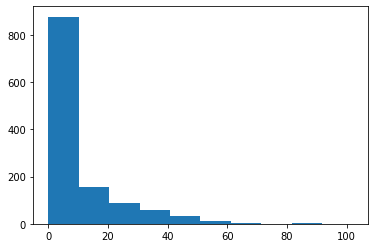

In [ ]:
plt.hist(lower_priced_products["mktg_embedding_counts_glov"])
plt.show()

In [ ]:
# Examine distribution of the number of marketing terms in the text for higher 
# priced products. 
higher_priced_products["mktg_embedding_counts_glov"].describe()

count    1232.000000
mean        8.787338
std        12.634662
min         0.000000
25%         1.000000
50%         4.000000
75%        12.000000
max       108.000000
Name: mktg_embedding_counts_glov, dtype: float64

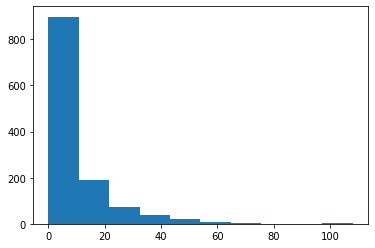

In [ ]:
plt.hist(higher_priced_products["mktg_embedding_counts_glov"])
plt.show()

#### Sentiment Analysis

In [ ]:
# Extract sentiment scores for each text using nltk SentimentIntensityAnalyzer.
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_df = hair_df["full_text"].apply(sentiment_analyzer.polarity_scores).to_frame()
sentiment_df  = sentiment_df["full_text"].apply(pd.Series)
# Add results to the main dataframe. 
hair_df["pos"] = sentiment_df["pos"]
hair_df["neg"] = sentiment_df["neg"]
hair_df["neu"] = sentiment_df["neu"]
hair_df["compound"] = sentiment_df["compound"]
# Examine values
hair_df[["pos","neg","neu","compound"]].head()

,pos,neg,neu,compound
0,0.204,0.044,0.752,0.8689
1,0.075,0.122,0.803,-0.2023
2,0.141,0.120,0.739,0.2263
3,0.000,0.000,1.000,0.0000
4,0.228,0.000,0.772,0.7003


In [ ]:
# Split products based on price. 
lower_priced_products = hair_df[hair_df["price_unit"] <= cutoff_hair] 
higher_priced_products = hair_df[hair_df["price_unit"] > cutoff_hair]

In [ ]:
# Examine sentiment scores for the lower priced products.
lower_priced_products[["pos","neg","neu","compound"]].describe()

,pos,neg,neu,compound
count,1232.000000,1232.000000,1232.000000,1232.000000
mean,0.182294,0.018390,0.799310,0.714098
std,0.102369,0.033779,0.105961,0.376015
min,0.000000,0.000000,0.406000,-0.840200
25%,0.115000,0.000000,0.730000,0.612400
50%,0.193000,0.000000,0.790500,0.896800
75%,0.249000,0.028000,0.866250,0.969000
max,0.594000,0.292000,1.000000,0.998700


In [ ]:
# Examine sentiment scores for the higher priced products. 
higher_priced_products[["pos","neg","neu","compound"]].describe()

,pos,neg,neu,compound
count,1232.000000,1232.000000,1232.00000,1232.000000
mean,0.169657,0.017519,0.81283,0.663473
std,0.105497,0.036884,0.11027,0.393575
min,0.000000,0.000000,0.44000,-0.855500
25%,0.100000,0.000000,0.73575,0.493900
50%,0.173000,0.000000,0.80800,0.848100
75%,0.245000,0.023000,0.88500,0.957100
max,0.560000,0.329000,1.00000,0.999400


### Authenticity

#### Term Frequency - Inverse Document Frequency  
TFIDF gives a score for each token/word in 1 document of documents cominbed into one. For authenticy, we want the words and its tfidf over the whole lower price "document" and higher price "document" (lower_priced_products, higher_priced_products)

In [ ]:
#  Create TFIDF data for lower priced hairs: titles, about, and description
lower_title_tf = tfidf(lower_priced_products.title_cl, col_name='l_title_tfidf')
lower_about_tf = tfidf(lower_priced_products.about_cl, col_name='l_about_tfidf')
lower_desc_tf = tfidf(lower_priced_products.description_cl, col_name='l_desc_tfidf')

#  Create TFIDF data for higher priced hairs: titles, about, and description
higher_title_tf = tfidf(higher_priced_products.title_cl, col_name='h_title_tfidf')
higher_about_tf = tfidf(higher_priced_products.about_cl, col_name='h_about_tfidf')
higher_desc_tf = tfidf(higher_priced_products.description_cl, col_name='h_desc_tfidf')

['silicon mix silicon mix bambu extract nutrit prod oz ounc clay esth prod ex oz refil rainbow research henna hair color prod persian copper oz red avalon organ strengthen peppermint prod prod set ounc scent secret hawaiian ginger prod prod bodi wash ounc tigi bed head colour combat colour goddess prod ounc schwarzkopf bc bonacur smooth shine prod unmanag hair mloz mizani miracl milk leavein prod moistur detangl spray frizzi curli hair design essenti strengthen therapi sulfat free prod oz panten radiant color volum prod oz pack shikai natur volum prod add full textur fine thin hair ounc jason revit vitamin e prod ounc bottl pack panten prov radiant color shine dream care prod prod vibrant shine oz pack tigi bed head like hot heat humid resist prod smooth sooth ounc remi hair style tangl free silk mist leavein prod oz coppola keratin complex clarifi prod ounc bottl aphog prod damag hair fl oz lot cream silk prod standout straight straighter hair creamsilk ml ogx prod brazilian keratin t

In [ ]:
# Create TFIDF dataframe for lower priced products
lower_tf = lower_title_tf.join(lower_about_tf, how='outer')
lower_tf = lower_tf.join(lower_desc_tf, how='outer')
lower_tf['word'] = lower_tf.index
lower_tf.sort_values(by=['l_desc_tfidf'], ascending=False).head(30)

,l_title_tfidf,l_about_tfidf,l_desc_tfidf,word
hair,0.243264,0.748543,0.706335,hair
prod,0.779860,0.341208,0.400664,prod
moistur,0.100680,0.162522,0.164803,moistur
natur,0.069115,0.110209,0.142115,natur
oil,0.089795,0.133427,0.126657,oil
color,0.069115,0.114912,0.123665,color
product,0.005986,0.116675,0.122917,product
use,0.002177,0.104332,0.105713,use
help,0.004898,0.104919,0.101475,help
clean,0.019592,0.106683,0.095242,clean


In [ ]:
# Create TFIDF dataframe for higher priced products
higher_tf = higher_title_tf.join(higher_about_tf, how='outer')
higher_tf = higher_tf.join(higher_desc_tf, how='outer')
higher_tf['word'] = higher_tf.index
higher_tf.sort_values(by=['h_desc_tfidf'], ascending=False).head(30)

,h_title_tfidf,h_about_tfidf,h_desc_tfidf,word
hair,0.245107,0.761475,0.752358,hair
prod,0.758765,0.362374,0.368224,prod
color,0.074598,0.130687,0.136663,color
moistur,0.054350,0.117833,0.124162,moistur
natur,0.058080,0.127627,0.121036,natur
oil,0.060211,0.136808,0.113649,oil
product,0.009058,0.079881,0.105410,product
use,0.002131,0.111099,0.104841,use
help,0.004263,0.097633,0.101432,help
scalp,0.043693,0.092736,0.088931,scalp


In [ ]:
# Create joined TFIDF dataframe
tfidf_joined = lower_tf.merge(higher_tf, how='outer', on ='word')
tfidf_joined = tfidf_joined[['word', 'l_title_tfidf', 'h_title_tfidf',	'l_about_tfidf', 'h_about_tfidf', 'l_desc_tfidf', 'h_desc_tfidf']]
tfidf_joined.sort_values(by='l_title_tfidf', ascending=False) # sort to see, change by accordingly 

,word,l_title_tfidf,h_title_tfidf,l_about_tfidf,h_about_tfidf,l_desc_tfidf,h_desc_tfidf
3580,prod,0.779860,0.758765,0.341208,0.362374,0.400664,0.368224
3275,oz,0.394012,0.474228,0.050843,0.079575,0.076293,0.075009
3246,ounc,0.250883,0.209406,0.023805,0.031830,0.040391,0.034095
2022,hair,0.243264,0.245107,0.748543,0.761475,0.706335,0.752358
1705,fl,0.115918,0.098576,0.008229,0.009488,0.019447,0.011081
...,...,...,...,...,...,...,...
7717,zingib,NaN,NaN,NaN,NaN,NaN,0.000284
7718,zip,NaN,NaN,NaN,0.000306,NaN,NaN
7719,zipper,NaN,NaN,NaN,0.000306,NaN,NaN
7720,zizyphu,NaN,NaN,NaN,NaN,NaN,0.000284


### Health


*   Ingredients from Amazon Products 
*   Toxicity Levels from California Chemicals in Cosmetics Database 



In [ ]:
# Check if ingredient exists in our data
hair_df[hair_df['ingredients'].str.contains('retinol', na=False)][["product_title_cl","ingredients"]]

,product_title_cl,ingredients


In [ ]:
hair_df.ingredients.unique()[0:3]

array([nan,
       'Lawsonia inermis (red henna), indigofereae (black henna) and cassia obovata (neutral henna).',
       'Honey, Oat, Vitamin E'], dtype=object)

In [ ]:
# Retrieve count of toxic ingredients.
hair_df['toxic_count'] = hair_df['ingredients'].apply(lambda x: check_toxic(x) if pd.notnull(x) else None)

In [ ]:
# Retrieve list of toxic ingredients. 
hair_df['toxic_ing'] = hair_df['ingredients'].apply(lambda x: check_toxic_ingredient(x) if pd.notnull(x) else None)

In [ ]:
# Split products based on price. 
lower_priced_products = hair_df[hair_df["price_unit"] <= cutoff_hair] 
higher_priced_products = hair_df[hair_df["price_unit"] > cutoff_hair]

In [ ]:
# Examine distribution of toxic ingredients for lower priced products. 
lower_priced_products["toxic_count"].describe() 

count    508.000000
mean       0.250000
std        0.542567
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: toxic_count, dtype: float64

In [ ]:
# Examine distribution of toxic ingredients for higher  priced products.
higher_priced_products["toxic_count"].describe() 

count    453.000000
mean       0.253863
std        0.523361
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: toxic_count, dtype: float64

## Modeling

In [ ]:
# Truncate all text to a max length of 100
hair_df["full_text_trunc"] = hair_df["full_text"].apply(truncate_or_fill)

#### Neural Network (Definition) 

Used for the baseline and the improvement.[link text](https://)

### Train Test Split

In [ ]:
# Split data into train and test.
random_df = pd.DataFrame(np.random.randn(hair_df["full_text_trunc"].shape[0]))
mask = np.random.rand(len(random_df)) < 0.8
train_features = hair_df[mask]
train_labels = hair_df["price_unit"][mask].fillna(0)
test_features = hair_df[~mask]
test_labels = hair_df["price_unit"][~mask].fillna(0)

In [ ]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1958, 29)
(1958,)
(506, 29)
(506,)


### Baseline
Run a Neural Network with features computed during the Freedman and Jurafsky Analysis

In [ ]:
# Scale a dataframe column
def scale_data(data):
  min_max_scaler = preprocessing.StandardScaler()
  data_scaled = min_max_scaler.fit_transform(data)
  return pd.DataFrame(data_scaled)

In [ ]:
hair_df["marketing_term_count_scaled"] = scale_data((hair_df["marketing_term_count_raw"]+1).values.reshape(-1,1))
hair_df["flesch_kincaid_grade_scaled"] = scale_data((hair_df["flesch_kincaid_grade"]).values.reshape(-1,1))
hair_df["reading_ease_scaled"] = scale_data((hair_df["reading_ease"]).values.reshape(-1,1))
hair_df["lexicon_count_scaled"] = scale_data((hair_df["lexicon_count"]).values.reshape(-1,1))
hair_df["mktg_embedding_counts_glov_scaled"] = scale_data((hair_df["mktg_embedding_counts_glov"]).values.reshape(-1,1))
hair_df["compound_scaled"] = scale_data((hair_df["compound"]).values.reshape(-1,1))
hair_df["toxic_count_scaled"] = scale_data((hair_df["toxic_count"]).values.reshape(-1,1))

Experiments

In [ ]:
# Scaled Data
# Mean Absolute Error, Mean Squared Error  [1.1124241352081299, 4.136312961578369]
train = hair_df[["marketing_term_count_scaled" , "flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "compound_scaled","toxic_count_scaled"]][mask]
test = hair_df[["marketing_term_count_scaled" , "flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "compound_scaled","toxic_count_scaled"]][~mask]

# Results of using Unscaled Features. 
# Mean Absolute Error, Mean Squared Error  [1.065545678138733, 4.275307655334473]
train = hair_df[["marketing_term_count_raw" , "flesch_kincaid_grade" , "reading_ease" , "lexicon_count" , "mktg_embedding_counts_glov" , "compound","toxic_count"]][mask]
test = hair_df[["marketing_term_count_raw" , "flesch_kincaid_grade" , "reading_ease" , "lexicon_count" , "mktg_embedding_counts_glov" , "compound","toxic_count"]][~mask]

# Scaled and neu instead of compount
# Mean Absolute Error, Mean Squared Error  [1.0878902673721313, 4.176847457885742]
train = hair_df[["marketing_term_count_scaled" ,"flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "neu","toxic_count_scaled"]][mask]
test = hair_df[["marketing_term_count_scaled" ,"flesch_kincaid_grade_scaled" , "reading_ease_scaled" , "lexicon_count_scaled" , "mktg_embedding_counts_glov_scaled" , "neu","toxic_count_scaled"]][~mask]

In [ ]:
run_model((train.shape[1],), train, train_labels, test, test_labels, 200)

Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 2.4025 - mse: 14.4474
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.8594 - mse: 10.5798
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5196 - mse: 10.7446
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4704 - mse: 10.0479
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3759 - mse: 8.8936
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4217 - mse: 8.9688
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4462 - mse: 9.4850
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4765 - mse: 9.7544
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4410 - mse: 9.1129
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3789 - mse: 8.6651
Epoch 11/200
62/62 [==============================] - 0

### Improvement 
Use Embeddings and pass them through a Neural Net as well as a Convolutional Neural Net.


#### ELMO - Contextualized Word Embeddings

In [ ]:
  elmo_embeddings_train_path_hair = '/content/gdrive/MyDrive/266/final/data/elmo_embeddings_train_hair.npy'
  elmo_embedding_test_path_hair = '/content/gdrive/MyDrive/266/final/data/elmo_embeddings_test_hair.npy'

In [ ]:
create_and_save_elmo_embeddings(elmo_embeddings_train_path_hair,elmo_embedding_test_path_hair)

In [ ]:
# Load pre-saved elmo word embeddings 
elmo_embeddings_hair = np.load(elmo_embeddings_train_path_hair)
elmo_embeddings_hair_test = np.load(elmo_embedding_test_path_hair)

In [ ]:
print("elmo_embeddings_hair shape: ", elmo_embeddings_hair.shape)
print("elmo_embeddings_hair_test shape: ", elmo_embeddings_hair_test.shape)

elmo_embeddings_hair shape:  (1958, 1024)
elmo_embeddings_hair_test shape:  (506, 1024)


#### BERT (Variations) Embeddings
Semi-Adapted from [Source](https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb)

 **DistilBERT**

In [ ]:
distilbert_embeddings_train_path_hair = "/content/gdrive/MyDrive/266/final/data/distilbert_embeddings_train_hair.npy"
distilbert_embeddings_test_path_hair =  "/content/gdrive/MyDrive/266/final/data/distilbert_embeddings_test_hair.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, distilbert_embeddings_train_path_hair  , bert_type="distilbert")
create_and_save_bert_embeddings(test_features, distilbert_embeddings_test_path_hair, bert_type="distilbert")

100%|██████████| 6/6 [01:02<00:00, 10.34s/it]


In [ ]:
# Load pre-saved DistilBERT word embeddings 
distilbert_embeddings_hair = np.load(distilbert_embeddings_train_path_hair)
distilbert_embeddings_hair_test = np.load(distilbert_embeddings_test_path_hair)

In [ ]:
print("distilbert_embeddings_hair shape: ", distilbert_embeddings_hair.shape)
print("distilbert_embeddings_hair_test shape: ", distilbert_embeddings_hair_test.shape)

distilbert_embeddings_hair shape:  (1958, 768)
distilbert_embeddings_hair_test shape:  (506, 768)


 **RoBERTa**

In [ ]:
roberta_embeddings_train_path_hair = "/content/gdrive/MyDrive/266/final/data/roberta_embeddings_train_hair.npy"
roberta_embeddings_test_path_hair =  "/content/gdrive/MyDrive/266/final/data/roberta_embeddings_test_hair.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, roberta_embeddings_train_path_hair  , bert_type="roberta")
create_and_save_bert_embeddings(test_features, roberta_embeddings_test_path_hair, bert_type="roberta")

100%|██████████| 6/6 [01:52<00:00, 18.76s/it]


In [ ]:
# Load pre-saved RoBERTa word embeddings 
roberta_embeddings_hair = np.load(roberta_embeddings_train_path_hair)
roberta_embeddings_hair_test = np.load(roberta_embeddings_test_path_hair)

In [ ]:
print("roberta_embeddings_hair shape: ", roberta_embeddings_hair.shape)
print("roberta_embeddings_hair_test shape: ", roberta_embeddings_hair_test.shape)

roberta_embeddings_hair shape:  (1958, 768)
roberta_embeddings_hair_test shape:  (506, 768)


**BERT (original)**

In [ ]:
bert_embeddings_train_path_hair = "/content/gdrive/MyDrive/266/final/data/bert_embeddings_train_hair.npy"
bert_embeddings_test_path_hair =  "/content/gdrive/MyDrive/266/final/data/bert_embeddings_test_hair.npy"

In [ ]:
create_and_save_bert_embeddings(train_features, bert_embeddings_train_path_hair  , bert_type="bert")
create_and_save_bert_embeddings(test_features, bert_embeddings_test_path_hair, bert_type="bert")

100%|██████████| 6/6 [02:04<00:00, 20.81s/it]


In [ ]:
# Load pre-saved RoBERTa word embeddings 
bert_embeddings_hair = np.load(bert_embeddings_train_path_hair)
bert_embeddings_hair_test = np.load(bert_embeddings_test_path_hair)

In [ ]:
print("bert_embeddings shape: ", bert_embeddings_hair.shape)
print("bert_embeddings_test shape: ", bert_embeddings_hair_test.shape)

bert_embeddings shape:  (1958, 768)
bert_embeddings_test shape:  (506, 768)


### Neural Network - Run for Improvement

In [ ]:
# ELMO
run_model((1024,), elmo_embeddings_hair, train_labels, elmo_embeddings_hair_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [1.1777405738830566, 4.052495002746582]
"""

Epoch 1/200
62/62 [==============================] - 1s 2ms/step - loss: 1.4644 - mse: 8.4311
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5035 - mse: 10.4092
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4173 - mse: 8.9808
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4737 - mse: 9.1023
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5537 - mse: 11.3299
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4462 - mse: 9.5241
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4417 - mse: 9.1316
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4913 - mse: 10.6525
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2690 - mse: 6.9687
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4283 - mse: 8.2753
Epoch 11/200
62/62 [==============================] - 0s

'\nMean Absolute Error, Mean Squared Error  [1.1777405738830566, 4.052495002746582]\n'

In [ ]:
# DistilBERT
run_model((768,), distilbert_embeddings_hair, train_labels, distilbert_embeddings_hair_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [1.0419797897338867, 3.6801388263702393]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.6316 - mse: 10.6465
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4207 - mse: 9.5812
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4691 - mse: 9.5364
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3735 - mse: 8.3415
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4638 - mse: 9.9147
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4129 - mse: 8.8541
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3570 - mse: 7.8905
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3717 - mse: 9.1481
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3138 - mse: 7.1682
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4108 - mse: 10.0043
Epoch 11/200
62/62 [==============================] - 0s 

'\nMean Absolute Error, Mean Squared Error  [1.0419797897338867, 3.6801388263702393]\n'

In [ ]:
# RoBERTa
run_model((768,), roberta_embeddings_hair, train_labels, roberta_embeddings_hair_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [1.0948551893234253, 3.6444075107574463]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5634 - mse: 9.2003
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4195 - mse: 8.5031
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4111 - mse: 8.3168
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4226 - mse: 8.3040
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3354 - mse: 7.3659
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3334 - mse: 7.7708
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3588 - mse: 8.5390
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3865 - mse: 8.3252
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2834 - mse: 7.7309
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3030 - mse: 7.7155
Epoch 11/200
62/62 [==============================] - 0s 2m

'\nMean Absolute Error, Mean Squared Error  [1.0948551893234253, 3.6444075107574463]\n'

In [ ]:
# BERT
run_model((768,), bert_embeddings_hair, train_labels, bert_embeddings_hair_test, test_labels, 200)
"""
Mean Absolute Error, Mean Squared Error  [1.102107286453247, 3.9629263877868652]
"""

Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 1.5286 - mse: 8.2813
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4737 - mse: 10.1940
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4550 - mse: 9.3647
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4326 - mse: 9.3068
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2993 - mse: 7.9065
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 1.4236 - mse: 9.6917
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2948 - mse: 7.4466
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3973 - mse: 9.7729
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 1.2967 - mse: 7.2143
Epoch 10/200
62/62 [==============================] - 0s 2ms/step - loss: 1.3476 - mse: 7.9626
Epoch 11/200
62/62 [==============================] - 0s 2

'\nMean Absolute Error, Mean Squared Error  [1.102107286453247, 3.9629263877868652]\n'

### Convolutional Neural Network

In [ ]:
# ELMO
cnn = train_cnn(elmo_embeddings_hair, train_labels)
results = cnn.evaluate(elmo_embeddings_hair_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.0965903997421265, 4.228530406951904]
"""

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 3.0894 - mse: 18.7270
Epoch 2/100
62/62 [==============================] - 0s 4ms/step - loss: 2.6560 - mse: 15.5926
Epoch 3/100
62/62 [==============================] - 0s 4ms/step - loss: 2.3380 - mse: 14.2014
Epoch 4/100
62/62 [==============================] - 0s 4ms/step - loss: 2.2299 - mse: 14.1784
Epoch 5/100
62/62 [==============================] - 0s 4ms/step - loss: 1.9779 - mse: 11.0737
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 1.7767 - mse: 9.1741
Epoch 7/100
62/62 [==============================] - 0s 4ms/step - loss: 1.8177 - mse: 10.6047
Epoch 8/100
62/62 [==============================] - 0s 4ms/step - loss: 1.7639 - mse: 11.1267
Epoch 9/100
62/62 [==============================] - 0s 4ms/step - loss: 1.7517 - mse: 11.4102
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 1.6960 - mse: 10.9168
Epoch 11/100
62/62 [==============================

'\nMean Absolute Error, Mean Squared Error:  [1.0965903997421265, 4.228530406951904]\n'

In [ ]:
# DistilBERT
cnn = train_cnn(distilbert_embeddings_hair, train_labels)
results = cnn.evaluate(distilbert_embeddings_hair_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.1034969091415405, 4.20483922958374]
"""

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 4.7458 - mse: 38.9410
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 4.0884 - mse: 30.5212
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 3.3034 - mse: 20.6200
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 2.7051 - mse: 17.4467
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 2.4662 - mse: 14.7212
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 2.1286 - mse: 12.5889
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9129 - mse: 10.8416
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 1.8160 - mse: 11.2455
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 1.6211 - mse: 9.1382
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 1.6570 - mse: 10.5760
Epoch 11/100
62/62 [==============================

'\nMean Absolute Error, Mean Squared Error:  [1.1034969091415405, 4.20483922958374]\n'

In [ ]:
# RoBERTa
cnn = train_cnn(roberta_embeddings_hair, train_labels)
results = cnn.evaluate(roberta_embeddings_hair_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.096874475479126, 4.2369842529296875]
"""

Epoch 1/100
62/62 [==============================] - 1s 3ms/step - loss: 10.3868 - mse: 183.9371
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 8.4864 - mse: 122.9593
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 6.9309 - mse: 79.4580
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 5.6594 - mse: 55.2301
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 4.3554 - mse: 33.7093
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 3.3545 - mse: 21.7102
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 2.8056 - mse: 16.7771
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 2.4768 - mse: 14.9388
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 2.0583 - mse: 10.5381
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9477 - mse: 11.6070
Epoch 11/100
62/62 [==========================

'\nMean Absolute Error, Mean Squared Error:  [1.096874475479126, 4.2369842529296875]\n'

In [ ]:
# BERT
cnn = train_cnn(bert_embeddings_hair, train_labels)
results = cnn.evaluate(bert_embeddings_hair_test, test_labels)
print("Mean Absolute Error, Mean Squared Error: ", results)
"""
Mean Absolute Error, Mean Squared Error:  [1.0969746112823486, 4.288430213928223]
"""

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 4.9289 - mse: 44.2796
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 3.8069 - mse: 25.8879
Epoch 3/100
62/62 [==============================] - 0s 3ms/step - loss: 3.1898 - mse: 21.7969
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 2.6972 - mse: 15.8188
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 2.2985 - mse: 13.0689
Epoch 6/100
62/62 [==============================] - 0s 4ms/step - loss: 1.9688 - mse: 10.1394
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 1.9911 - mse: 11.9988
Epoch 8/100
62/62 [==============================] - 0s 3ms/step - loss: 1.7148 - mse: 10.4861
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 1.6843 - mse: 9.7888
Epoch 10/100
62/62 [==============================] - 0s 4ms/step - loss: 1.5878 - mse: 8.3759
Epoch 11/100
62/62 [==============================]

'\nMean Absolute Error, Mean Squared Error:  [1.0969746112823486, 4.288430213928223]\n'